# Установка зависимостей

In [ ]:
CUDA_CORE=1
MODEL_USED="facebook/nllb-200-distilled-600M"
# MODEL_USED="facebook/nllb-200-1.3B"
LANGUAGE_ORIGIN_LABEL="nivkh_Cyrl"
LANGUAGE_TARGET_LABEL="rus_Cyrl"
LANGUAGE_SIMILAR_LABEL="bak_Cyrl"
LANGUAGE_FILE_ORIGIN_LABEL="nivkh"
LANGUAGE_FILE_TARGET_LABEL="rus"
NORMALIZER_LANGUAGE="ru"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH="/content/drive/MyDrive/models/nllb_nivkh_rus_600M_amur_extended"
!mkdir -p {MODEL_SAVE_PATH}

In [ ]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [ ]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu bitsandbytes accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install ipywidgets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.9 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn -q
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import seaborn as sns
from IPython.display import clear_output
from IPython.utils import io
import torch
import time
from torch import optim
from torch.nn import functional as F
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer
import shutil
import pickle
import os
import re
import json

# Обработка данных

In [ ]:
data = []

input_dir = '/content/drive/MyDrive/translation_resplit3'
srcs = [
    '_agm', '_shklg', '_shtrn', '_sng', '_grz',
    'a158_bible', 'a159_bible', 'a160_bible',
    'a161_bible', 'a162_bible', 'a163_bible', 'a164_bible'
]
for filename in tqdm(os.listdir(input_dir)):
    if filename.endswith('.txt') and not any(src in filename for src in srcs):
        full_path = os.path.join(input_dir, filename)
        tag_match = re.search(r'_(\w+)\.txt$', filename)
        tag = tag_match.group(1) if tag_match else None
        with open(full_path, 'r', encoding='utf-8') as f:
            src, tgt = None, None
            for line in f:
                if re.match(r'^\d+>', line):
                    src = re.sub(r'^\d+>\s*', '', line).strip()
                elif re.match(r'^\d+=', line):
                    tgt = re.sub(r'^\d+=\s*', '', line).strip()
                    if src is not None:
                        data.append({
                            'nivkh': src,
                            'rus': tgt,
                            'file': filename,
                            'source': tag
                        })
                        src, tgt = None, None
print(len(data))

  0%|          | 0/99 [00:00<?, ?it/s]

4724


In [ ]:
with open('/content/drive/MyDrive/FilteredNivkhTxt/valid.json') as json_file:
    valid_files = json.load(json_file)

srcs = [
    '_agm', '_shklg', '_shtrn', '_sng', '_grz',
    'a158_bible', 'a159_bible', 'a160_bible',
    'a161_bible', 'a162_bible', 'a163_bible', 'a164_bible'
]
for filename in tqdm(valid_files):
    if filename.endswith('.txt') and not any(src in filename for src in srcs):
        full_path = os.path.join(input_dir, filename)
        tag_match = re.search(r'_(\w+)/n_r_p.txt$', filename)
        tag = tag_match.group(1) if tag_match else None
        with open(full_path, 'r', encoding='utf-8') as f:
            src, tgt = None, None
            for line in f:
                if re.match(r'^\d+>', line):
                    src = re.sub(r'^\d+>\s*', '', line).strip()
                elif re.match(r'^\d+=', line):
                    tgt = re.sub(r'^\d+=\s*', '', line).strip()
                    if src is not None:
                        data.append({
                            'nivkh': src,
                            'rus': tgt,
                            'file': filename,
                            'source': tag
                        })
                        src, tgt = None, None
print(len(data))

  0%|          | 0/253 [00:00<?, ?it/s]

6535


In [ ]:
df = pd.DataFrame(data)
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
6530,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6531,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6532,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6533,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
df['nivkh_norm'] = df['nivkh'].str.lower().str.strip()
df['rus_norm'] = df['rus'].str.lower().str.strip()
df = df.drop_duplicates(subset=['nivkh_norm', 'rus_norm']).drop(columns=['nivkh_norm', 'rus_norm']).reset_index(drop=True)
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
6353,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6354,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6355,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6356,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
def restore_nivkh_capitalization(sents):
    capitalized_sents = []
    char_map = {
    'ӄ': 'Ӄ',
    'ӈ': 'Ӈ',
    'ӽ': 'Ӽ',
    'ғ': 'Ғ',
    'ҳ': 'Ҳ',
    'χ': 'Χ',
    'ӻ': 'Ӻ',
    'р̌': 'Р̌',
    'ӿ': 'Ӿ',
    'ў': 'Ў'
}
    for sent in sents:
        if not sent:
            capitalized_sents.append(sent)
            continue
        first_char = sent[0]
        rest_of_sent = sent[1:]
        if first_char in char_map.keys():
            capitalized_first = char_map[first_char]
        else:
            capitalized_first = first_char.upper()
        capitalized_sent = capitalized_first + rest_of_sent
        capitalized_sents.append(capitalized_sent)
    return capitalized_sents

In [ ]:
df['nivkh'] = restore_nivkh_capitalization(df['nivkh'])
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
6353,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6354,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6355,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6356,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
ENGLISH_WORDS = re.compile(r'\b[a-zA-Z]+\b')
URLS = re.compile(r'https?://\S+|www\.\S+')
EMAILS = re.compile(r'\S+@\S+')
PHONES = re.compile(r'(\+?\d[\d\s\-()]{6,})')
BRACKETS = re.compile(r'\[[^\]]*\]|\([^\)]*\)')
JUNK = re.compile(r'[~*^%$@#_=<>\\|]')

def clean_text(text):
    text = URLS.sub('', text)
    text = EMAILS.sub('', text)
    text = PHONES.sub('', text)
    text = BRACKETS.sub('', text)
    text = ENGLISH_WORDS.sub('', text)
    text = JUNK.sub('', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
def clean_up(sents):
    map = {
        'ь:': 'ь.', 'Ē~ӽ': 'Ех', 'ѵ': 'у', 'Ē': 'Е', 'ā': 'а', 'ñ': '', '×': 'у',
        'ī': 'и', 'Ō': 'О', 'ō': 'о', 'р̃': 'р̌', 'р̆': 'р̌', '~': '-',
        '§.': '', 'ÿ': 'у', 'ʻ': '', 'ʼ': "'", 'р˘': 'р̌', 'р̀': 'р̌',
        '́': '', '̃': '', '̄': '', '̉': '', '̍': '', '̔': 'р', '̣': '',
        '̥': '', '̨': '', '̬': '', '̓': '', 'џ': 'ц', 'ґ': 'г', 'Ҥ': 'Ӈ',
        'Ң': 'Ӈ', 'ң': 'ӈ', 'Ӊ': 'Ӈ', 'ӊ': 'ӈ', 'ҧ': 'п', 'Ұ': 'ӻ',
        'ӗ': 'е', 'Өа х': 'Х', 'ӯ': 'у', 'ӱ': 'у', 'ӧ': 'ё', 'ҳ': 'х',
        '՚': "'", 'ḗ': 'е', 'ṓ': 'о', 'ṕ': 'р̌', '‑': '-', '‐': '-',
        '–': '-', '—': '-', '‘': "'", '’': "'", '“': '"', '”': '"',
        '«': '"', '»': '"', '•': '', '…': '...', '▸': '', 'Р̆': 'Р̌',
        'ē': 'е', 'Ӿ ': '! ', 'Ӿ" ': '!" ', "\\'": "'"
    }
    cleaned_sents = []
    for sent in sents:
        for old, new in map.items():
            sent = sent.replace(old, new)
            sent = clean_text(sent)
        cleaned_sents.append(sent.replace("\\", ""))
    return cleaned_sents

In [ ]:
df['nivkh'] = clean_up(df['nivkh'])
df['rus'] = clean_up(df['rus'])
df

,nivkh,rus,file,source
0,Лаӄр̌.,Белка.,a185_tmn.txt,tmn
1,Ӄан лаӄр̌ ньр̌ыдь.,Собака белку увидела.,a185_tmn.txt,tmn
2,Лаӄр̌ ӄой сродь.,Белка на лиственницу забралась.,a185_tmn.txt,tmn
3,Ӄан ығдь.,Собака лает.,a185_tmn.txt,tmn
4,Ромкин лаӄр̌ амадь.,Ромкин на белку смотрит.,a185_tmn.txt,tmn
...,...,...,...,...
6353,- Чыӈ профессия гражданское общество служениеғ...,- Ваша профессия связана со служением гражданс...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6354,Наф пандемияух сык СМИ намагур рают'адьғу.,Особо хочу отметить роль СМИ в ситуации с панд...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6355,Валерий Лимаренко СМИ представительғу поздравл...,Поздравляя представителей СМИ с профессиональн...,/content/drive/MyDrive/FilteredNivkhTxt/a266_n...,nd
6356,"Тэӈилоӈ ӈамӄ куух Россия Северухке, Сибирьухке...",Президент Ассоциации коренных малочисленных на...,/content/drive/MyDrive/FilteredNivkhTxt/a104_n...,nd


In [ ]:
df['source'] = df['source'].str.replace('srhsh', 'shrsh', regex=False)

In [ ]:
sources = list(set(df['source']))
sources

['nd', 'gdn', 'pnf', 'bible', 'hrn', 'ptmn', 'tmn', 'shrsh']

In [ ]:
df_train, df_devtest = train_test_split(df, test_size=0.2, random_state=42, stratify=df['source'])
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42, stratify=df_devtest['source'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5086 entries, 4445 to 4477
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   5086 non-null   object
 1   rus     5086 non-null   object
 2   file    5086 non-null   object
 3   source  5086 non-null   object
dtypes: object(4)
memory usage: 198.7+ KB


In [ ]:
df_train.head()

,nivkh,rus,file,source
4445,Вығркун р̌амдьғудята?,Выгшкуны где жили?,11_shrsh.txt,shrsh
3894,"Ӿыдьғу сык кыӈгу, ӿыдьғу сык-сык р̌ур̌, п'оғла...","Это всё заморозит, это всё собирает и кормит с...",15_shrsh.txt,shrsh
3703,"Чыӈ яғат нерх ӿыйкудьӈа, чыӈ яғат нерх ӿыйкудьӈа?","Вы зачем меня отметили, вы зачем меня отметили?",24_shrsh.txt,shrsh
609,Ӿоӻор т'оӻ ӈохкир хэдрра т'ыкр̌-кир р̌овра.,"Потом натер жиром сохатого, багульником обкурил.",a147_pnf.txt,pnf
272,Ч'эрӻа йикидьра.,Ты мне не под силу.,a147_pnf.txt,pnf


In [ ]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636 entries, 350 to 702
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   636 non-null    object
 1   rus     636 non-null    object
 2   file    636 non-null    object
 3   source  636 non-null    object
dtypes: object(4)
memory usage: 24.8+ KB


In [ ]:
df_dev.head()

,nivkh,rus,file,source
350,Ӿоӻоӈан иф йочч.,Тогда он спросил.,a147_pnf.txt,pnf
4658,"- Ӄ'ауӄра, ни чи иньғытныӄана, ни чык весӄарӈа...","- Нет, я съем тебя, потому что я сильнее, - от...",/content/drive/MyDrive/FilteredNivkhTxt/67_nd/...,nd
4291,Тиғр ағағӈан тылфтох вийныдьлян.,"Далеко не уидёт, палка мешает.",11_shrsh.txt,shrsh
868,Эӻздь иф сык ӈағу палух парк эрх п'рыныдьғу иф...,"Он подумал, что все звери в лесу сами к нему п...",a128_gdn.txt,gdn
446,Т'а п'лызигувэ.,Мимо себя не пропустите.,a147_pnf.txt,pnf


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 636 entries, 5990 to 46
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nivkh   636 non-null    object
 1   rus     636 non-null    object
 2   file    636 non-null    object
 3   source  636 non-null    object
dtypes: object(4)
memory usage: 24.8+ KB


In [ ]:
df_test.head()

,nivkh,rus,file,source
5990,"Ӿы имущество список ӿара, пай химиныф ӿара Южн...",Список этого имущества и сам факт его безвозме...,/content/drive/MyDrive/FilteredNivkhTxt/86_nd/...,nd
205,Ӿоӻар мэр ӈафӄ пыиздь ит'ых п'ыньдь.,"Наш товарищ бросил, в его лоб бросил.",a147_pnf.txt,pnf
3918,"Ӿы п'оғлагу п'ерх лағт п'р̌ыкуӈан, п'оғлагу аз...","Когда наши дети приезжают к нам в гости, угоща...",15_shrsh.txt,shrsh
4223,"Ӿонф, имгу нана пандӈан.","Раней весной, когда они рождаются.",11_shrsh.txt,shrsh
5365,"Кремлевский оркестр Пила Ваф луғу ""В землянке""...",Государственный Кремлевский оркестр посетил ос...,/content/drive/MyDrive/FilteredNivkhTxt/a420_n...,nd


# Настройка модели

## Настройка токенизатора

In [ ]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [ ]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [ ]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [ ]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,nivkh,nivkh_words,nivkh_toks,rus,rus_words,rus_toks
3257,"П'ытык ытыкху аӻар йыймта, сык сык рамхты п'ытык.","[П, ', ытык, ытыкху, аӻар, йыймта, ,, сык, сык...","[▁П, ', ы, тык, ▁ы, тык, ху, ▁а, ӻ, ар, ▁йы, й...","Xорошо познакомилась со своими родственниками,...","[Xорошо, познакомилась, со, своими, родственни...","[▁X, оро, шо, ▁позна, коми, лась, ▁со, ▁своими..."
2588,Нерӄух тыйроӽ мағть тиғрку.,"[Нерӄух, тыйроӽ, мағть, тиғрку, .]","[▁Н, ер, ӄ, у, х, ▁ты, й, ро, ӽ, ▁ма, ғ, ть, ▁...",Я пошёл на марь.,"[Я, пошёл, на, марь, .]","[▁Я, ▁по, ш, ёл, ▁на, ▁мар, ь, .]"
2883,"Ӿыть чо ӿуӈк, Пырких ӈырт.","[Ӿыть, чо, ӿуӈк, ,, Пырких, ӈырт, .]","[▁, Ӿ, ы, ть, ▁чо, ▁, ӿ, у, ӈ, к, ,, ▁П, ыр, к...","Рыба там, на реке Пырки маленьким неводом рыба...","[Рыба, там, ,, на, реке, Пырки, маленьким, нев...","[▁Р, ы, ба, ▁там, ,, ▁на, ▁ре, ке, ▁П, ыр, ки,..."
4576,"Резник Семён Владимирович номинация ""Народный ...","[Резник, Семён, Владимирович, номинация, "", На...","[▁Рез, ник, ▁С, ем, ён, ▁Влади, ми, рови, ч, ▁...","Резника Семёна Владимировича в номинации ""Прои...","[Резника, Семёна, Владимировича, в, номинации,...","[▁Рез, ника, ▁С, ем, ёна, ▁Влади, ми, рови, ча..."
5761,Лығивоталоӈ 17 куух Лер Миф область художестве...,"[Лығивоталоӈ, 17, куух, Лер, Миф, область, худ...","[▁Л, ы, ғи, во, та, ло, ӈ, ▁17, ▁куу, х, ▁Л, е...",В Сахалинском областном художественном музее с...,"[В, Сахалинском, областном, художественном, му...","[▁В, ▁Са, ха, лин, ском, ▁област, ном, ▁худо, ..."


In [ ]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

<ipython-input-34-8bf0a8236e3f>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,nivkh_toks,rus_toks,nivkh_words,rus_words
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,25.778900,17.44630,11.865300,10.392800
std,23.235934,17.35579,10.717912,9.214912
min,2.000000,2.00000,2.000000,2.000000
25%,11.000000,7.00000,5.000000,5.000000
50%,18.000000,12.00000,8.000000,7.000000
75%,32.000000,21.00000,15.000000,13.000000
max,227.000000,212.00000,106.000000,115.000000


In [ ]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

2.172629432041331
1.6786910168578248


In [ ]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


In [ ]:
texts_with_unk = [text for text in tqdm(df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/6358 [00:00<?, ?it/s]

13


In [ ]:
import random
s = random.sample(texts_with_unk, 5)
s

['Наӻвгун засмеявшись говорит:',
 '"пофӄ ноноӄ" так говорят?',
 'Моя старшая сестра Чӈыр̌к за ними ухаживает.',
 'Для сравнения представим статистику по заражению коронавирусом на прошлых неделях: \ue12c с 6 по 12 августа заболело 167 человек \ue12c с 30 июля по 5 августа заболело 116 человек \ue12c с 23 по 29 июля заболело 60 человек.',
 'Но не только, и у нерпёнок до года название бывает, "пофӄ" это возрастное название нерпы которая только что родилась.']

In [ ]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/13 [00:00<?, ?it/s]

12


## Расширение словаря

In [ ]:
from collections import Counter
all_texts = df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common()
    if v >= 3 and k not in ' '
])

  0%|          | 0/6358 [00:00<?, ?it/s]

In [ ]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [ ]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=6055,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

In [ ]:
# !pip install protobuf==3.19.4 --force-reinstall

In [ ]:
# !wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

In [ ]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 263178
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 6973

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 260683
4478


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 260683. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


  0%|          | 0/4478 [00:00<?, ?it/s]

## Добавление тэга нового языка в токенизатор и модель

In [ ]:
print('nivkh_Cyrl' in tokenizer.get_vocab())
print('rus_Cyrl' in tokenizer.get_vocab())

False
True


In [ ]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_ORIGIN_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
fix_tokenizer(tokenizer)

In [ ]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

260626 260500


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 260684. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(260684, 1024)

In [ ]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# Обучение (A100)

## Предварительные шаги

In [ ]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [ ]:
# model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).to('cuda')
# tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
# fix_tokenizer(tokenizer)

In [ ]:
model.to('cuda')

M2M100ForConditionalGeneration(
  (model): M2M100Model(
    (shared): Embedding(260684, 1024)
    (encoder): M2M100Encoder(
      (embed_tokens): Embedding(260684, 1024)
      (embed_positions): M2M100SinusoidalPositionalEmbedding()
      (layers): ModuleList(
        (0-11): 12 x M2M100EncoderLayer(
          (self_attn): M2M100Attention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwi

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [ ]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 20000

In [ ]:
import json

losses = []
# with open('/content/drive/MyDrive/models/nllb_nivkh_rus_600M_amur_extended/losses.json') as json_file:
#     losses = json.load(json_file)
# losses

In [ ]:
# losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [ ]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

NameError: name 'random' is not defined

## Циклы обучения (по тренировочным шагам)

In [ ]:
#@title 0-11k

import json
import os

LOSS_FILE = os.path.join(MODEL_SAVE_PATH, "losses.json")

model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

        if i % 100 == 0:
            with open(LOSS_FILE, 'w') as f:
                json.dump(losses, f)

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

with open(LOSS_FILE, 'w') as f:
    json.dump(losses, f)

  0%|          | 0/20000 [00:00<?, ?it/s]

0 8.045448303222656
1000 4.753950049638748
2000 2.6781447546482084
3000 2.045718920826912
4000 1.6104806144833566
5000 1.28899938082695
6000 1.0203097353577615
7000 0.7969341825842857
8000 0.6161725512742996
9000 0.4787610973417759
10000 0.37706977823376653
11000 0.293281084895134
12000 0.2372413786649704
13000 0.18953770804405212
14000 0.15203633756935597
15000 0.12249403527751565
16000 0.10419151177257299
17000 0.08682373794540763
18000 0.0734339250344783
19000 0.06470504459738731


<Axes: >

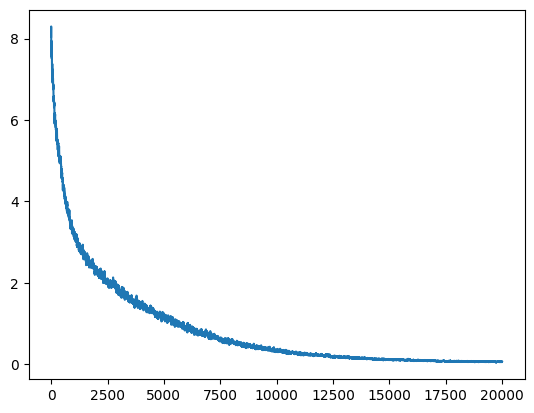

In [ ]:
pd.Series(losses).ewm(10).mean().plot()

In [ ]:
!ls -alsh $MODEL_SAVE_PATH

total 2.4G
625K -rw------- 1 root root 625K May 30 23:02 all_texts_file.csv
1.0K -rw------- 1 root root  896 May 31 01:31 config.json
 512 -rw------- 1 root root  184 May 31 01:31 generation_config.json
397K -rw------- 1 root root 397K May 31 01:39 losses.json
2.4G -rw------- 1 root root 2.4G May 31 01:31 pytorch_model.bin
4.8M -rw------- 1 root root 4.8M May 31 01:31 sentencepiece.bpe.model
3.5K -rw------- 1 root root 3.5K May 31 01:31 special_tokens_map.json
367K -rw------- 1 root root 367K May 30 23:02 spm_16k.model
140K -rw------- 1 root root 140K May 30 23:02 spm_16k.vocab
4.8M -rw------- 1 root root 4.8M May 30 23:02 spm_nllb_268k.model
1.0K -rw------- 1 root root  570 May 31 01:31 tokenizer_config.json


# Тестирование

In [ ]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [ ]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['Ӿыдь, мындьғи ӿаӈан и, ӿы мындьғи чафчавар, лотлотор пердь ӿағр, ыр̌к кутиныр лель.']
['Это обувь из рыбьей кожи, намокли, стали тяжёлые, уже хотят сползти.']
['Когда хотят на пласты, немного просушится, немного портится, долго нюхает, и наступит спячку.']


In [ ]:
t = "Ӿы нивх лу?"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['Этот человек?']


In [ ]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['Этот человек?']

In [ ]:
t = "Это правда!"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['ыть мыхтькир та?']


In [ ]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['ыть мыхтькир та!']

In [ ]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [ ]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/636 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)

In [ ]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 17.14 44.8/19.4/12.6/9.9 (BP = 0.943 ratio = 0.945 hyp_len = 5585 ref_len = 5913)
chrF2++ = 37.79
BLEU = 17.15 44.6/19.5/12.6/9.0 (BP = 0.968 ratio = 0.969 hyp_len = 6378 ref_len = 6583)
chrF2++ = 35.86


In [ ]:
from collections import defaultdict

# метрики по источникам
scores = defaultdict(dict)
for src, df in df_test.groupby('source'):
    # nivkh --> rus
    refs_n2r = [df[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]
    preds_n2r = df[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist()
    scores[src]['bleu_NR'] = bleu_calc.corpus_score(preds_n2r, refs_n2r)
    scores[src]['chrf_NR'] = chrf_calc.corpus_score(preds_n2r, refs_n2r)
    # rus --> nivkh
    refs_r2n = [df[LANGUAGE_FILE_TARGET_LABEL].tolist()]
    preds_r2n = df[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist()
    scores[src]['bleu_RN'] = bleu_calc.corpus_score(preds_r2n, refs_r2n)
    scores[src]['chrf_RN'] = chrf_calc.corpus_score(preds_r2n, refs_r2n)

for src, s in scores.items():
    print(src)
    print('--------')
    for name, val in s.items():
        print(f'{name}: {val}')
    print()

bible
--------
bleu_NR: BLEU = 7.67 44.6/15.5/5.0/1.7 (BP = 0.869 ratio = 0.877 hyp_len = 448 ref_len = 511)
chrf_NR: chrF2++ = 33.00
bleu_RN: BLEU = 10.77 43.2/15.9/6.8/3.2 (BP = 0.975 ratio = 0.975 hyp_len = 512 ref_len = 525)
chrf_RN: chrF2++ = 30.73

gdn
--------
bleu_NR: BLEU = 3.39 35.0/5.6/1.3/0.8 (BP = 0.907 ratio = 0.912 hyp_len = 103 ref_len = 113)
chrf_NR: chrF2++ = 25.96
bleu_RN: BLEU = 2.75 33.1/3.5/1.0/0.6 (BP = 0.969 ratio = 0.969 hyp_len = 127 ref_len = 131)
chrf_RN: chrF2++ = 19.66

hrn
--------
bleu_NR: BLEU = 4.27 23.3/7.1/1.9/1.0 (BP = 1.000 ratio = 1.224 hyp_len = 60 ref_len = 49)
chrf_NR: chrF2++ = 16.84
bleu_RN: BLEU = 4.24 29.4/6.4/2.3/1.3 (BP = 0.872 ratio = 0.879 hyp_len = 51 ref_len = 58)
chrf_RN: chrF2++ = 12.81

nd
--------
bleu_NR: BLEU = 25.64 51.0/29.6/21.3/16.7 (BP = 0.947 ratio = 0.949 hyp_len = 2525 ref_len = 2662)
chrf_NR: chrF2++ = 45.95
bleu_RN: BLEU = 22.01 44.7/25.3/18.5/14.3 (BP = 0.940 ratio = 0.942 hyp_len = 2619 ref_len = 2780)
chrf_RN: chrF2

In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
df_test.sample(30, random_state=77)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,rus,nivkh,rus_translated,nivkh_translated
3230,"Рано весной, в лес идет, поднимает медведя из берлоги, выгоняет, затем ловит медвежат и приносит...","Ыр̌ки ӿонвайӈан, мағр̌, чхыф озур̌ п'уғур, ӿарот ноноӄ вор̌, р̌ор мығр̌.","Как-то раз, когда спали, спрыгнул на голову медведи, схватился за свой нож, и спустился.","Т'ытки озр, палдох мырр, п'утух мығр, эғъёть, ӿатот р̌ор вир̌ имғу ворх ғер р̌ор вир̌."
4152,Тогда медведи гуляли.,Чӈыфку кмыӿат п'ут.,Охотились на медведя.,оӻаӈан ӄ'отр к'мыйдьғу.
788,"После этого, спеша, то бегом, то шагом обратно пошел.",Ӿарор̌ касказир̌ ӄамаӻамар̌ эғр̌ видь.,"После этого старик, невъяв, в бедро прыгнув, обратно пошел.",оӻор эньч хызр вира ӿарор̌ т'ылфтох п'хыдох.
4207,Бывают нерпы.,Лаӈр̌ку йивр̌ағар.,Есть тюленей.,аӻа ӈығр̌ты.
6317,"12. 2014 № 649 о действующих мероприятиях Закона Сахалинской области ""О наделении органов местно...","Лер Мивух нивғгу Лер Миф Правительство постановление ""В сфере защиты исконной среды обитания, тр...","Народов Южно-Сахалинска распоряжению Правительства Сахалинской области ""В сфере защиты исконной ...","15. 05. 2014 No 649 ""О распоряжению органов местного самодеяния Государственными полномочиями Са..."
1657,"В нашем селе, в Некрасовке, разные люди живут.",Ньыӈ воух Некрасовкаух ӄ'ать-ӄ'ать нивхгу ӿумдьғу.,В нашем селе Некрасовка наховает.,"Ньыӈ воух, Помр̌-воух, эна нивхгу ӿумдьғу."
3210,Их тренируют так.,Имғу тухтуғскир ӿоӈгут.,Их окурили.,Имӈ т'ах ӿоӈгут.
6209,"Когда это услышал Ирод, который был тогда царем в Иерусалиме, то забеспокоился, а с ним и весь И...","Ӿаӈан Иерусалимух царь му Ирод, ӿур мыр̌, азӈазӈадь, сык Иерусалим ӿан и хрыра.","Тогда царь решил поселиться в Иерусалиме, поднялся и появился, и весь Иерусалим появился.","оӄоӈан Иерусалимух царь Ирод мыӈан, эна п'и ӿазаӄр̌то мыхчр видь, сык Иерусалимғе ӿуртивт п'еспу..."
1370,"Если туда пойдешь, до твоего дома близко будет идти.",Ӿуктох виӻа п'рыфтох малэйгур̌ виныдьра.,"Если туда ехать, в свой дом много прошел.",оӄоӈан анти вит ч'рыфтох виныдьра.
1671,Первая пойманная рыба.,Нуғи иғ чо.,Сперва рыбу выстрелил.,Нуғи поймань ӿы.


# Сохранение на HF

In [ ]:
# на гугл-диске занимает много места, а на гитхабе файлы >1гб не проходят
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `4exam` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `4exam`


In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

model_load_name = "/content/drive/MyDrive/models/nllb_nivkh_rus_600M_amur_extended"
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name, config=cfg)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
upload_repo = "nllb_nivkh_rus_600M_amur_extended"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/4.96M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.48G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/el-izm/nllb_nivkh_rus_600M_amur_extended/commit/f54f585dc73180c372d2bb391f1c3357297dda14', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='f54f585dc73180c372d2bb391f1c3357297dda14', pr_url=None, repo_url=RepoUrl('https://huggingface.co/el-izm/nllb_nivkh_rus_600M_amur_extended', endpoint='https://huggingface.co', repo_type='model', repo_id='el-izm/nllb_nivkh_rus_600M_amur_extended'), pr_revision=None, pr_num=None)

# Квантизация

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoConfig

model_path = '/content/drive/MyDrive/models/nllb_nivkh_rus_600M_amur_extended'
cfg = AutoConfig.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path, config=cfg)

In [ ]:
import torch

model_int8 = torch.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear},
    dtype=torch.qint8
)
torch.save(model_int8, 'model_int8.pth')

In [ ]:
from transformers import NllbTokenizer

model = torch.load('model_int8.pth', weights_only=False, map_location='cpu')
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)

In [ ]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/636 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

In [ ]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 15.90 41.0/17.3/10.9/8.3 (BP = 1.000 ratio = 1.031 hyp_len = 6095 ref_len = 5913)
chrF2++ = 37.33
BLEU = 15.69 40.7/17.3/11.1/7.7 (BP = 1.000 ratio = 1.050 hyp_len = 6909 ref_len = 6583)
chrF2++ = 35.60


In [ ]:
from collections import defaultdict

# метрики по источникам
scores = defaultdict(dict)
for src, df in df_test.groupby('source'):
    # nivkh --> rus
    refs_n2r = [df[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]
    preds_n2r = df[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist()
    scores[src]['bleu_NR'] = bleu_calc.corpus_score(preds_n2r, refs_n2r)
    scores[src]['chrf_NR'] = chrf_calc.corpus_score(preds_n2r, refs_n2r)
    # rus --> nivkh
    refs_r2n = [df[LANGUAGE_FILE_TARGET_LABEL].tolist()]
    preds_r2n = df[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist()
    scores[src]['bleu_RN'] = bleu_calc.corpus_score(preds_r2n, refs_r2n)
    scores[src]['chrf_RN'] = chrf_calc.corpus_score(preds_r2n, refs_r2n)

for src, s in scores.items():
    print(src)
    print('--------')
    for name, val in s.items():
        print(f'{name}: {val}')
    print()

bible
--------
bleu_NR: BLEU = 5.96 39.3/12.6/3.8/0.8 (BP = 0.970 ratio = 0.971 hyp_len = 496 ref_len = 511)
chrf_NR: chrF2++ = 32.75
bleu_RN: BLEU = 11.77 40.1/15.6/7.4/4.1 (BP = 1.000 ratio = 1.030 hyp_len = 541 ref_len = 525)
chrf_RN: chrF2++ = 32.01

gdn
--------
bleu_NR: BLEU = 1.44 22.4/1.1/0.6/0.4 (BP = 0.945 ratio = 0.947 hyp_len = 107 ref_len = 113)
chrf_NR: chrF2++ = 19.27
bleu_RN: BLEU = 2.79 31.6/4.1/0.9/0.5 (BP = 1.000 ratio = 1.038 hyp_len = 136 ref_len = 131)
chrf_RN: chrF2++ = 19.86

hrn
--------
bleu_NR: BLEU = 3.98 23.3/5.4/1.9/1.0 (BP = 1.000 ratio = 1.224 hyp_len = 60 ref_len = 49)
chrf_NR: chrF2++ = 15.47
bleu_RN: BLEU = 4.53 35.1/5.7/2.0/1.1 (BP = 0.983 ratio = 0.983 hyp_len = 57 ref_len = 58)
chrf_RN: chrF2++ = 17.43

nd
--------
bleu_NR: BLEU = 23.31 45.7/25.6/18.1/14.0 (BP = 1.000 ratio = 1.044 hyp_len = 2779 ref_len = 2662)
chrf_NR: chrF2++ = 44.93
bleu_RN: BLEU = 19.93 39.3/21.4/15.8/11.9 (BP = 1.000 ratio = 1.041 hyp_len = 2893 ref_len = 2780)
chrf_RN: chrF2